In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
data = pd.read_csv('/Users/rutvikdhopate/Downloads/2gaussian.txt', delimiter = '\t', header = None)

In [4]:
x, y = [], []
with open('/Users/rutvikdhopate/Downloads/2gaussian.txt') as file:
    for line in file:
        x.append(line.split(' ')[0])
        y.append(line.split(' ')[1][:-2])

In [5]:
x = np.array(x).astype(np.float64)
y = np.array(y).astype(np.float64)

In [6]:
data = pd.DataFrame(columns = ["x","y"])

In [7]:
data["x"] = x
data["y"] = y

In [8]:
data = data.values

In [33]:
#Set some random parameter values 
mu1,mu2 = np.random.random(2), np.random.random(2)
sigma1, sigma2 = [[-1,0],[0,-1]], [[4,2],[2,2]]
w1 = np.random.random()
w2 = 1-w1

In [8]:
from scipy.stats import multivariate_normal

In [53]:
mv1 = multivariate_normal(mu1, sigma1)
mv2 = multivariate_normal(mu2, sigma2)

In [88]:
prob_1 = w1*mv1.pdf(data)

In [90]:
prob_2 = w2*mv2.pdf(data)

In [103]:
np.where(prob_1>prob_2)[0].shape

(917,)

In [107]:
np.where(prob_1>prob_2, 1,0)

array([0, 0, 1, ..., 0, 0, 0])

In [109]:
pi_df = pd.DataFrame(columns = ["n1","n2"])
pi_df["n1"] = np.where(prob_1>prob_2, 1,0)
pi_df["n2"] = np.where(prob_1<prob_2, 1,0)

In [110]:
pi_df

,n1,n2
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
5995,0,1
5996,1,0
5997,0,1
5998,0,1


In [113]:
data1 = data[pi_df[pi_df["n1"]==1].index]

In [116]:
np.mean(data1, axis=0)

array([2.30146799, 2.16358357])

In [118]:
np.var(data1, axis=0)

array([0.63635334, 2.455219  ])

In [133]:
subtracted = data1-np.mean(data1, axis=0)

In [150]:
cov = np.dot(subtracted.T, subtracted)/(data1.shape[0]-1)

In [152]:
new_w1 = data1.shape[0]/data.shape[0]

In [237]:
from scipy.stats import wishart
wishart.rvs(3, np.eye(2)) #df=3 where df>=dim and dim=2

array([[ 4.21116364, -4.27975193],
       [-4.27975193,  6.52151361]])

In [10]:
from scipy.stats import multivariate_normal

In [75]:
def posi_semi_defi(dim):
    rand_mat = np.random.rand(dim,dim)
    sym_mat = 0.5*(rand_mat+rand_mat.T)
    cov_mat = np.dot(sym_mat, sym_mat.T)
    return cov_mat

In [83]:
#Set some random parameter values 
mu1,mu2 = np.random.random(2), np.random.random(2)
cov1, cov2 = posi_semi_defi(2), posi_semi_defi(2)
# print(cov1, cov2)

# mu1, mu2 = [1,2], [3,5]
# sigma1, sigma2 = wishart.rvs(3, np.eye(2)), wishart.rvs(3, np.eye(2))
# cov1, cov2 = [[1,0],[0,4]], [[2,0.4],[0.4,2]]
w1 = np.random.random()
w2 = 1-w1
# w1, w2 = 0.5, 0.5
prev_prob1 = np.zeros(data.shape[0])
prev_prob2 = np.zeros(data.shape[0])
prob_1, prob_2 = np.ones(data.shape[0]), np.ones(data.shape[0])
iteration = 0
c1,c2 = 101, 101
# for iteration in tqdm(range(1000)):
# while not np.array_equal(np.column_stack((prev_prob1, prev_prob2)),np.column_stack((prob_1, prob_2))) or iteration<5000:
while not np.allclose(np.column_stack((prev_prob1, prev_prob2)),np.column_stack((prob_1, prob_2))) or iteration<2500:
# while c1 > 100 and c2 > 100 or iteration < 10000:
    prev_prob1 = prob_1
    prev_prob2 = prob_2
    
    #E-Step
    
    #Fit a multivariate normal distribution for the random parameters
    mv1 = multivariate_normal(mu1, cov1)
    mv2 = multivariate_normal(mu2, cov2)
    
    #Calculate the posterior probability of each data point
    prob_1 = w1*mv1.pdf(data)
    prob_2 = w2*mv2.pdf(data)

    prob_1 = prob_1/(prob_1+prob_2)
    prob_2 = prob_2/(prob_1+prob_2)

    # #Create the pi matrix based on posterior probability
    # pi_df = pd.DataFrame(columns = ["n1","n2"])
    # pi_df["n1"] = np.where(prob_1>prob_2, 1,0)
    # pi_df["n2"] = np.where(prob_1<prob_2, 1,0)


    #M-Step

    #Using the pi matrix, get the data for each of the two distributions
    # data1 = data[pi_df[pi_df["n1"]==1].index]
    # data2 = data[pi_df[pi_df["n2"]==1].index]

    #Calculate the updated parameters for both data
    # mu1 = np.mean(data1, axis=0)
    # mu2 = np.mean(data2, axis=0)

    mu1 = np.matmul(data.T,prob_1)/sum(prob_1)
    mu2 = np.matmul(data.T,prob_2)/sum(prob_2)

    # sub1 = data1-np.mean(data1, axis=0)
    # sub2 = data2-np.mean(data2, axis=0)

    # cov1 = np.dot(sub1.T, sub1)/(data1.shape[0])
    # cov2 = np.dot(sub2.T, sub2)/(data2.shape[0])

    sub1 = data-mu1
    sub2 = data-mu2

    cov1 = np.matmul((prob_1*sub1.T),sub1)/sum(prob_1)
    cov2 = np.matmul((prob_2*sub2.T),sub2)/sum(prob_2)
    
    # prod1 = np.einsum('ij,ik->ijk', sub1,sub1)
    # prod2 = np.einsum('ij,ik->ijk', sub2,sub2)

    # cov1 = np.dot(prod1.T, prob_1)/sum(prob_1)
    # cov2 = np.dot(prod2.T, prob_2)/sum(prob_2)
    
    # w1 = data1.shape[0]/data.shape[0]
    # w2 = 1-w1

    w1 = sum(prob_1)/data.shape[0]
    w2 = sum(prob_2)/data.shape[0]

    # c1 = np.sum((prob_1 - prev_prob1)/prev_prob1)
    # c2 = np.sum((prob_2 - prev_prob2)/prev_prob2)

    # prev_prob1 = prob_1
    # prev_prob2 = prob_2

    iteration+=1
    # print(iteration)

print(iteration)
print(mu1,mu2)
print(cov1,cov2)
print(w1,w2)

2500
[0.87298367 0.59275723] [0.86155947 0.0858679 ]
[[0.16559928 0.07282539]
 [0.07282539 0.03220756]] [[2.88675072 1.25167047]
 [1.25167047 1.65534187]]
0.004716801631031957 0.9885817813339133


In [46]:
np.dot(data.T,prob_1)/sum(prob_1)

array([5.68542004, 3.67232189])

In [27]:
np.dot((prob_1*sub1.T),sub1)/sum(prob_1)

array([[3.19751722, 1.80993971],
       [1.80993971, 1.85075737]])

In [22]:
(prob_1*sub1.T).shape

(2, 6000)

In [24]:
sub1.shape

(6000, 2)

In [124]:
np.column_stack((prob_1,prob_2))

array([[1.00000000e+000, 1.04047685e-161],
       [1.00000000e+000, 3.16453351e-052],
       [1.00000000e+000, 1.29728574e-206],
       ...,
       [1.00000000e+000, 7.95844003e-282],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000]])

In [129]:
np.sum((prob_1 - prev_prob1)/prob_1)

6000.0

In [38]:
np.dot(data.T,prob_1)/sum(prob_1)

array([2.38079374, 4.81212581])

In [95]:
prob_1[0]*sub1[0]*(sub1.T[0])

ValueError: operands could not be broadcast together with shapes (2,) (6000,) 

In [110]:
sub = data-mu1

In [111]:
prod = np.einsum('ij,ik->ijk', sub, sub)

In [112]:
np.dot(prod.T, prob_1)/sum(prob_1)

array([[0.48153333, 0.6464517 ],
       [0.6464517 , 2.27683878]])

In [77]:
np.dot(prob_1.reshape(6000,1).T,sub1).T

array([[-1.35891298e-13],
       [-5.64881475e-13]])

In [178]:
final_cov = [[0,0],[0,0]]
for i in range(data.shape[0]):
    mini_cov = prob_1[i]*((data[i]-mu1*np.array(data[i]-mu1).reshape(2,1)))/sum(prob_1)
    final_cov = final_cov+mini_cov

In [181]:
final_cov

array([[2.48808849, 4.89132051],
       [2.48808849, 4.89132051]])

In [29]:
# plt.scatter(data1[:,0],data1[:,1])
# plt.scatter(data2[:,0],data2[:,1])
# plt.show

In [3]:
x, y = [], []
with open('/Users/rutvikdhopate/Downloads/3gaussian.txt') as file:
    for line in file:
        x.append(line.split(' ')[0])
        y.append(line.split(' ')[1][:-2])

x = np.array(x).astype(np.float64)
y = np.array(y).astype(np.float64)

data = pd.DataFrame(columns = ["x","y"])
data["x"] = x
data["y"] = y

data = data.values

In [14]:
#Set some random parameter values
mu1,mu2,mu3 = np.random.random(2), np.random.random(2), np.random.random(2)
sigma1, sigma2, sigma3 = posi_semi_defi(2), posi_semi_defi(2), posi_semi_defi(2)
weights = np.random.rand(3)
weights = weights/weights.sum()
w1, w2, w3 = weights[0], weights[1], weights[2]

for iteration in tqdm(range(5000)):
    #E-Step
    
    #Fit a multivariate normal distribution for the random parameters
    mv1 = multivariate_normal(mu1, sigma1)
    mv2 = multivariate_normal(mu2, sigma2)
    mv3 = multivariate_normal(mu3, sigma3)

    #Calculate the posterior probability of each data point
    prob_1 = w1*mv1.pdf(data)
    prob_2 = w2*mv2.pdf(data)
    prob_3 = w3*mv3.pdf(data)
    
    #Create the pi matrix based on posterior probability
    prob_arrays = np.column_stack((prob_1, prob_2, prob_3))
    idx = np.argmax(prob_arrays, axis = 1)
    temp_arrays = np.zeros_like(prob_arrays)
    temp_arrays[np.arange(prob_arrays.shape[0]),idx] = 1
    
    pi_df = pd.DataFrame(temp_arrays.astype(int), columns = ["n1","n2","n3"])
    # print(pi_df)
    
    #M-Step
    
    #Using the pi matrix, get the data for each of the three distributions
    data1 = data[pi_df[pi_df["n1"]==1].index]
    data2 = data[pi_df[pi_df["n2"]==1].index]
    data3 = data[pi_df[pi_df["n3"]==1].index]

    # print(data3)
    #Calculate the updated parameters
    mu1 = np.mean(data1, axis=0)
    mu2 = np.mean(data2, axis=0)
    mu3 = np.mean(data3, axis=0)
    
    sub1 = data1-np.mean(data1, axis=0)
    sub2 = data2-np.mean(data2, axis=0)
    sub3 = data3-np.mean(data3, axis=0)
    
    cov1 = np.dot(sub1.T, sub1)/(data1.shape[0]-1)
    cov2 = np.dot(sub2.T, sub2)/(data2.shape[0]-1)
    cov3 = np.dot(sub3.T, sub3)/(data3.shape[0]-1)
    
    w1 = data1.shape[0]/data.shape[0]
    w2 = data2.shape[0]/data.shape[0]
    w3 = 1-w1-w2

print(mu1,mu2,mu3)
print(cov1,cov2,cov3)
print(w1,w2,w3)

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 963.00it/s]

[4.07011734 3.56122319] [7.10758881 3.77171345] [2.8093837  3.37416266]
[[3.71280257 1.49632864]
 [1.49632864 3.06387854]] [[0.98717073 0.58454973]
 [0.58454973 0.74814917]] [[0.44377557 0.73848242]
 [0.73848242 1.22944483]]
0.467 0.528 0.004999999999999893


In [46]:
#Set some random parameter values 
# mu1,mu2 = np.random.random(2), np.random.random(2)
mu1, mu2 = [1,2], [5,7]
sigma1, sigma2 = [[3,0],[0,3]], [[1,0],[0,1]]
w1 = np.random.random()
w2 = 1-w1

In [42]:
d1 = np.random.multivariate_normal(mu1, sigma1, round(6000*w1))
d2 = np.random.multivariate_normal(mu2, sigma2, round(6000*w2))

In [23]:
data = np.row_stack((d1,d2))

In [24]:
data

array([[ 0.02393482,  0.51501341],
       [ 0.59353706,  0.332985  ],
       [ 1.14158664,  0.89084295],
       ...,
       [ 1.50962403, -1.7516842 ],
       [ 1.57679548,  0.24291448],
       [-1.34675462, -0.80144579]])

In [63]:
mv1 = multivariate_normal(mu1, sigma1)
mv2 = multivariate_normal(mu2, sigma2)

In [64]:
prob_1 = mv1.pdf(data)
prob_2 = mv2.pdf(data)

In [65]:
prob_1 = w1*prob_1/(w1*prob_1+w2*prob_2)
prob_2 = w2*prob_2/(w1*prob_1+w2*prob_2)

(array([3.07156976e-53, 7.11409328e-53, 1.43032812e-50, ...,
        3.63970306e-03, 4.93786340e-02, 2.10260862e-01]),
 array([1, 1, 1, ..., 1, 1, 1]))

In [52]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

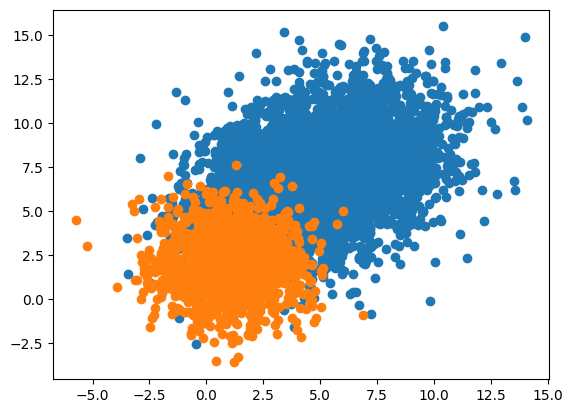

In [49]:
plt.scatter(d2[:,0],d2[:,1])
plt.scatter(d1[:,0],d1[:,1])



plt.show()